# Getting Started with Time Series

This notebook is my runthrough of [Konrad Banachewicz's excellent collection of tutorials](https://www.kaggle.com/code/konradb/ts-0-the-basics) covering most of the _non-transformer_ based modeling approaches used in this area. 

Videos for these tutorials can be found [here](https://www.youtube.com/watch?v=kAI67Sz92-s&list=PL-bdv-10yhrPGf9mNzQJvTc3yhhwpfOAz&index=1).

Alot of the work in these NBs is based on the popular [statsmodels](https://www.statsmodels.org/stable/index.html) library, in addition to other popular libraries like Prophet.

In [1]:
import pandas as pd
import numpy as np
from random import gauss
from pandas.plotting import autocorrelation_plot
import warnings, itertools, os, subprocess
from random import random
from pathlib import Path

import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import seaborn as sns

Konrad has a series of datasets, all compiled into a folder. So we can download all of these under a single data folder for easy retrieval.

In [2]:
# Setup credentials path and write once 
# Comment out once json file has been created.
#creds = '{"username":"bachaudhry","key":""}'
cred_path = Path('~/.kaggle/kaggle.json').expanduser()
if not cred_path.exists():
    cred_path.parent.mkdir(exist_ok=True)
    cred_path.write_text(creds)
    cred_path.chmod(0o600)

In [7]:
# Import datasets and unzip
def download_data(dataset, path):
    # Create local folder if one doesn't exist
    os.makedirs(path, exist_ok=True)
    # Call Kaggle API
    kaggle_call = f"kaggle datasets download -d {dataset} -p {path} --unzip"
    subprocess.run(kaggle_call, shell=True, check=True)
    print(f"Dataset '{dataset}' has been downloaded to '{path}'")

In [8]:
# Download Konrad's TS Dataset
dataset = "konradb/tsdata-1"
download_path = "data"

download_data(dataset, download_path)

Dataset URL: https://www.kaggle.com/datasets/konradb/tsdata-1
License(s): unknown


100%|██████████| 6.72M/6.72M [00:03<00:00, 1.89MB/s]



Dataset 'konradb/tsdata-1' has been downloaded to 'data'


In [9]:
# Configure image outputs
class CFG:
    img_dim1 = 20
    img_dim2 = 10

# Adjust Params
plt.rcParams.update({'figure.figsize': (CFG.img_dim1, CFG.img_dim2)})

## Visualizing Patterns in Time Series

Time series data will usually feature combinations of varying trends and seasonality - the modeling of which can either be Additive or Multiplicative depending on the use case. `statsmodels` allows us to carry out decompositions using `seasonal_decompose()` .

In [10]:
??seasonal_decompose

Signature:
seasonal_decompose(
    x,
    model='additive',
    filt=None,
    period=None,
    two_sided=True,
    extrapolate_trend=0,
)
Source:   
def seasonal_decompose(
    x,
    model="additive",
    filt=None,
    period=None,
    two_sided=True,
    extrapolate_trend=0,
):
    """
    Seasonal decomposition using moving averages.

    Parameters
    ----------
    x : array_like
        Time series. If 2d, individual series are in columns. x must contain 2
        complete cycles.
    model : {"additive", "multiplicative"}, optional
        Type of seasonal component. Abbreviations are accepted.
    filt : array_like, optional
        The filter coefficients for filtering out the seasonal component.
        The concrete moving average method used in filtering is determined by
        two_sided.
    period : int, optional
        Period of the series (e.g., 1 for annual, 4 for quarterly, etc). Must
        be used if x is not a pandas object or if the index of x does not have
 

### Examples From Konrad's Datasets - Airline Passengers

We will be using the Airline Passengers Dataset which was originally compiled by Box and Jenkins in 1976 and covers data from 1949 to 1960.

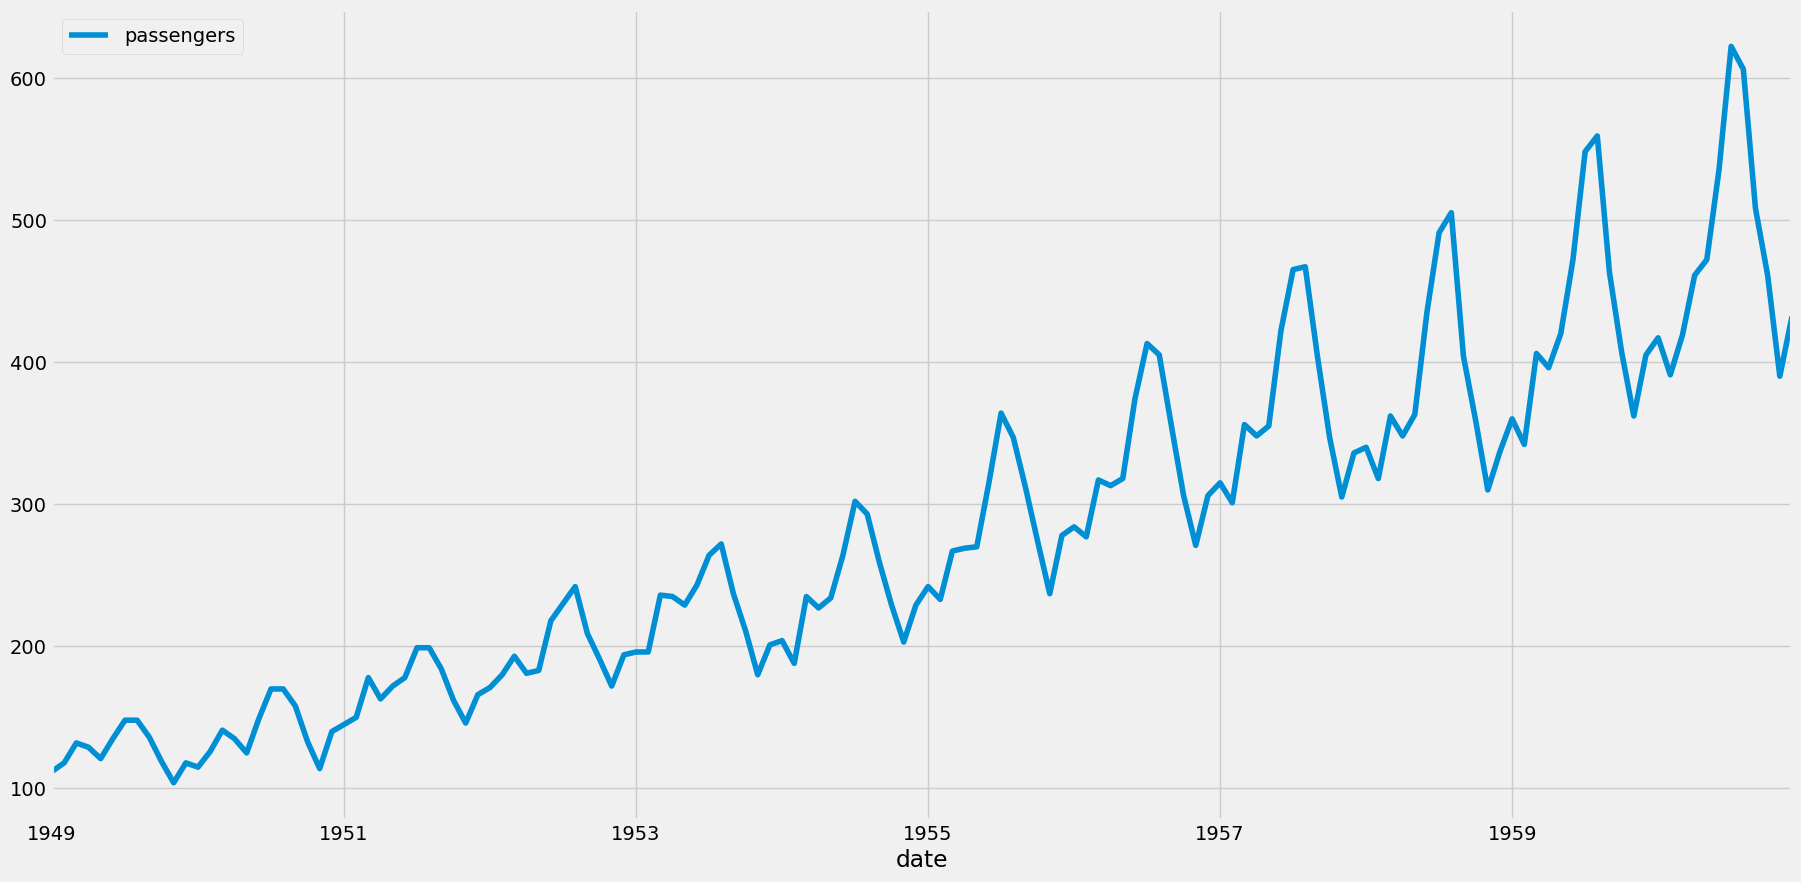

In [12]:
# Load airline passengers data and visualize
data = 'data/'
series = pd.read_csv(data + 'passengers.csv')
series['date'] = pd.to_datetime(series['date'])
series.set_index('date').plot();

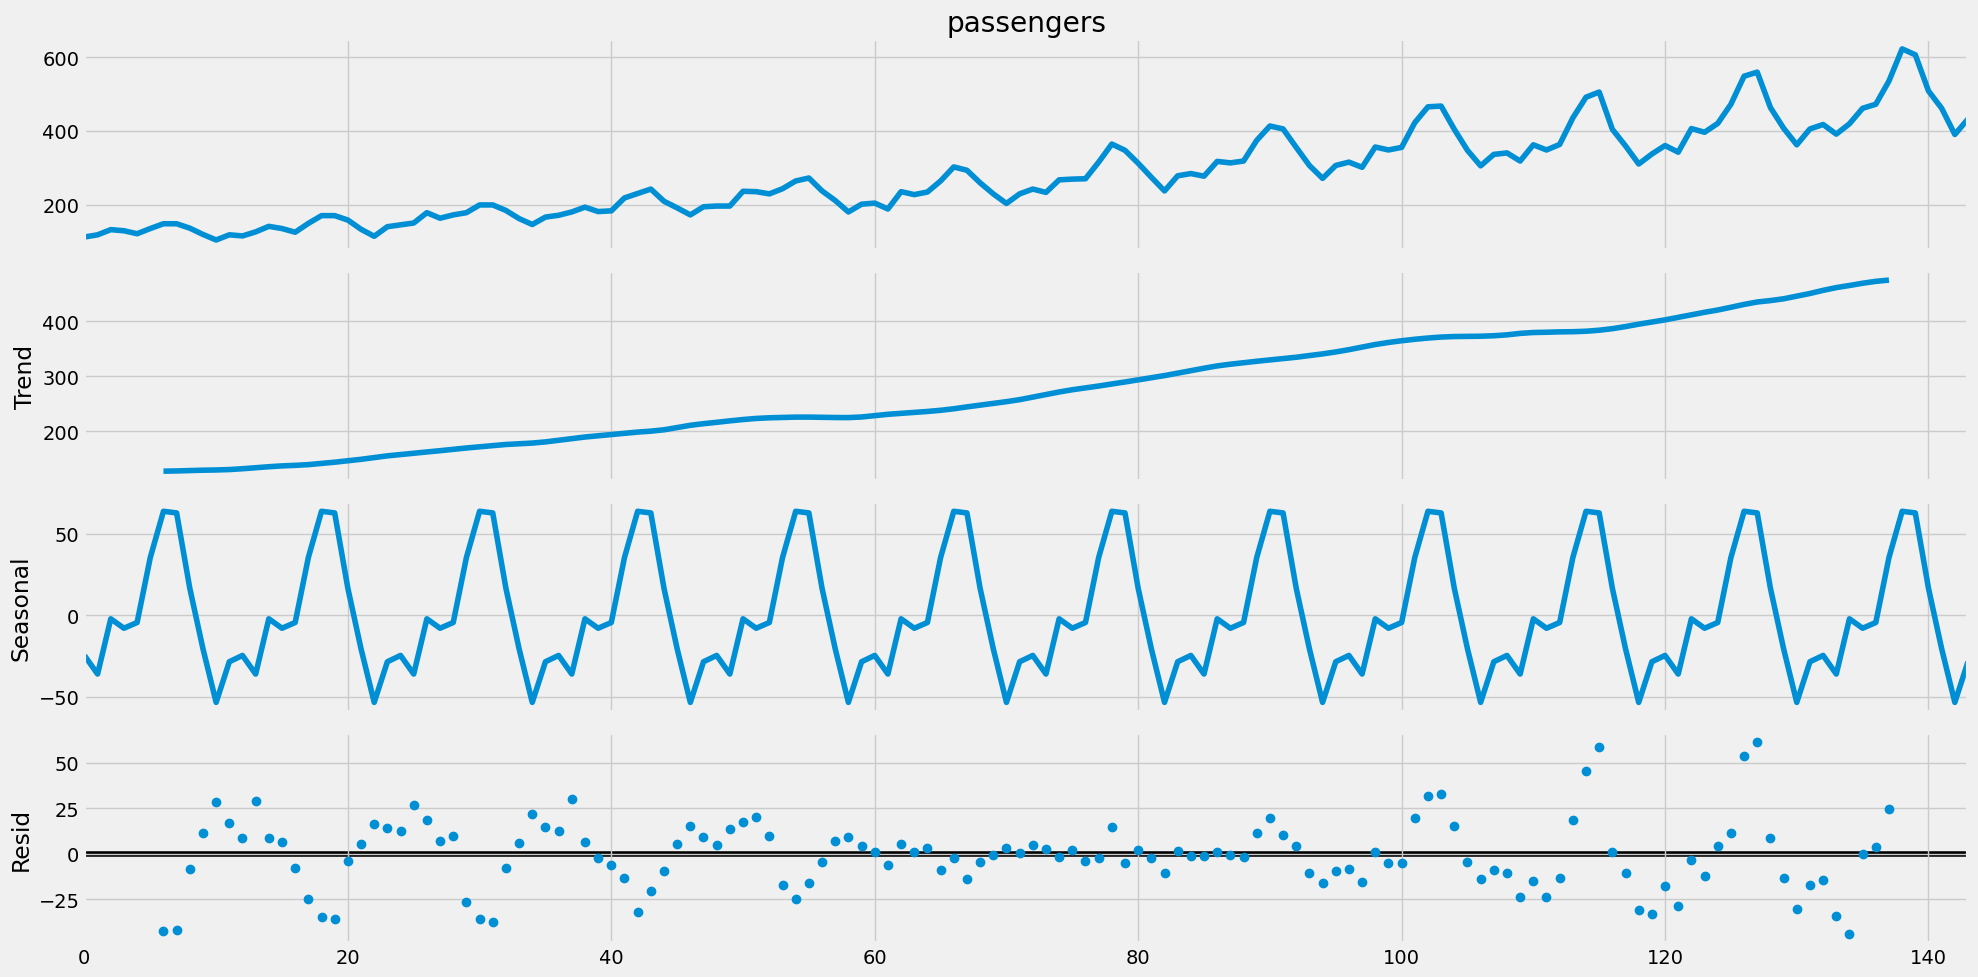

In [14]:
# Using additive decomposition
decomp = sm.tsa.seasonal_decompose(series['passengers'], period=12)
fig = decomp.plot()
plt.show();

Residuals do not appear to be consistent over time. We can further explore the additive vs multiplicative relationship between components:

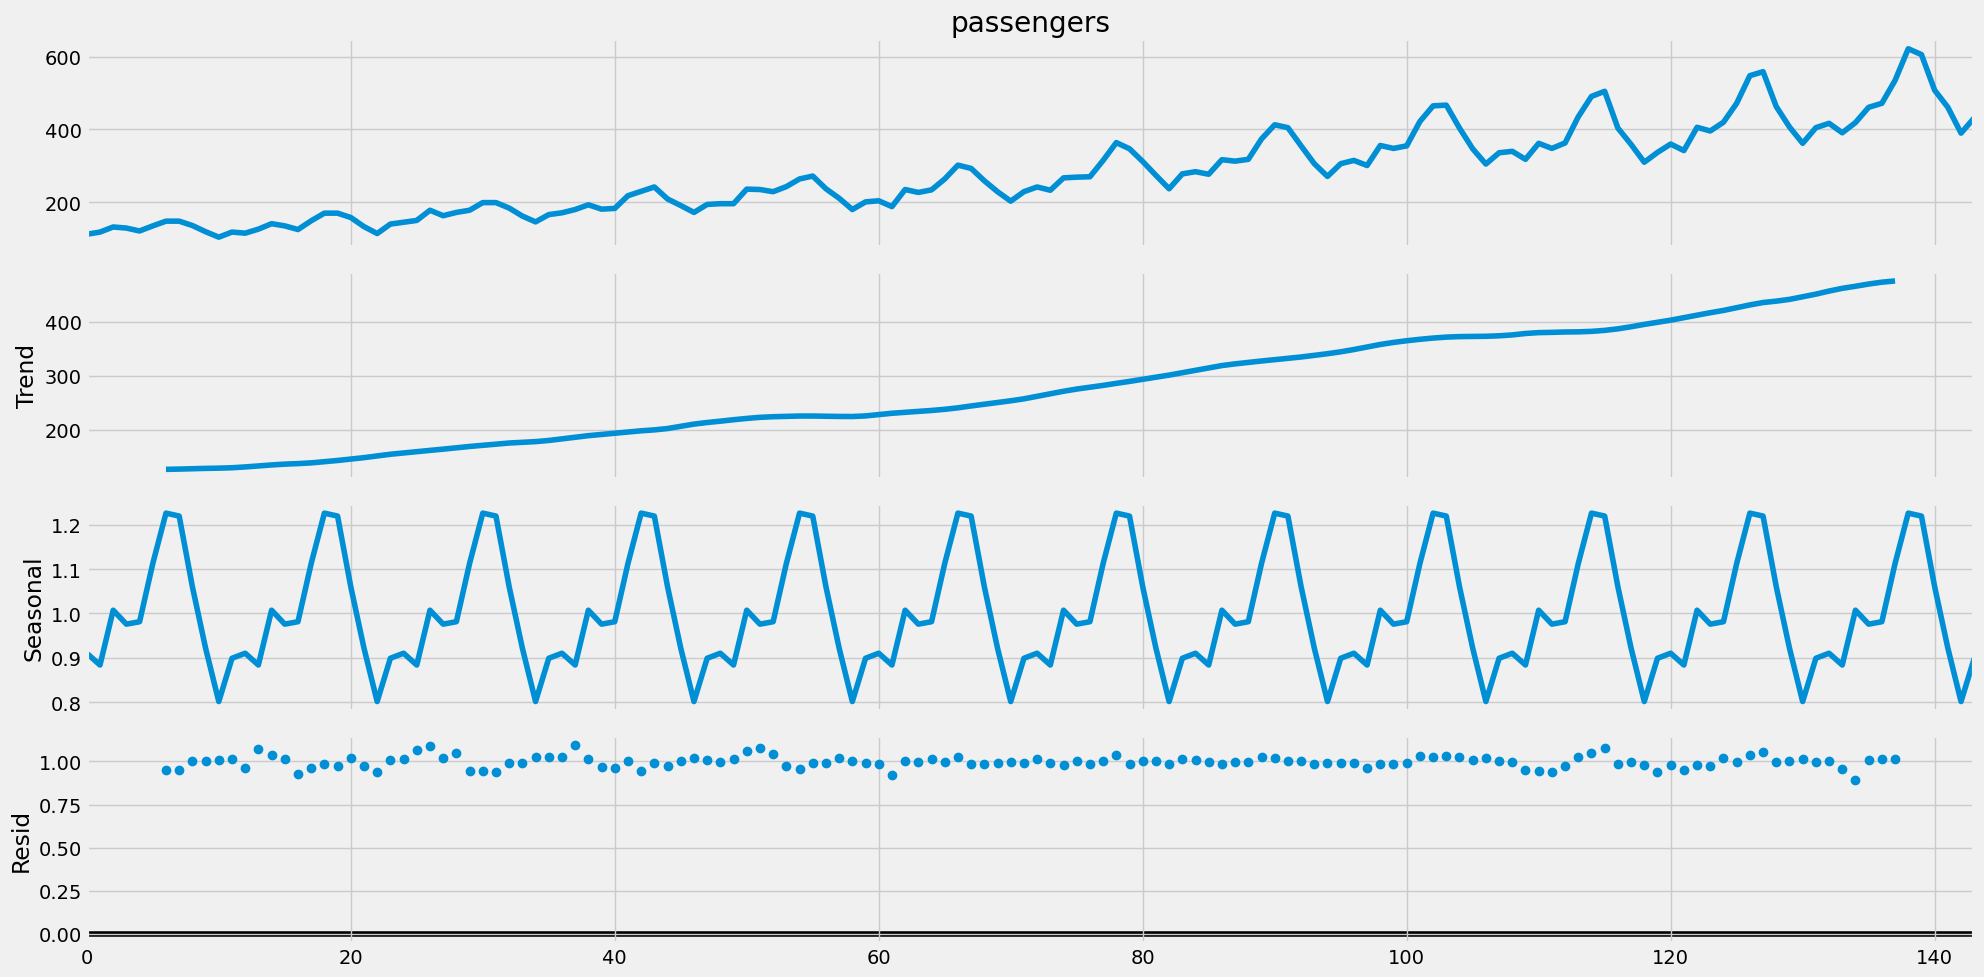

In [15]:
decomp = sm.tsa.seasonal_decompose(series['passengers'], period=12, model='multiplicative')
fig = decomp.plot()
plt.show()

The residuals look more stable around a constant level using the a multiplicative model. However, we should note that this phenomena does not necessarily imply stationarity.

### Examples From Konrad's Datasets - Levels of Savings in the US

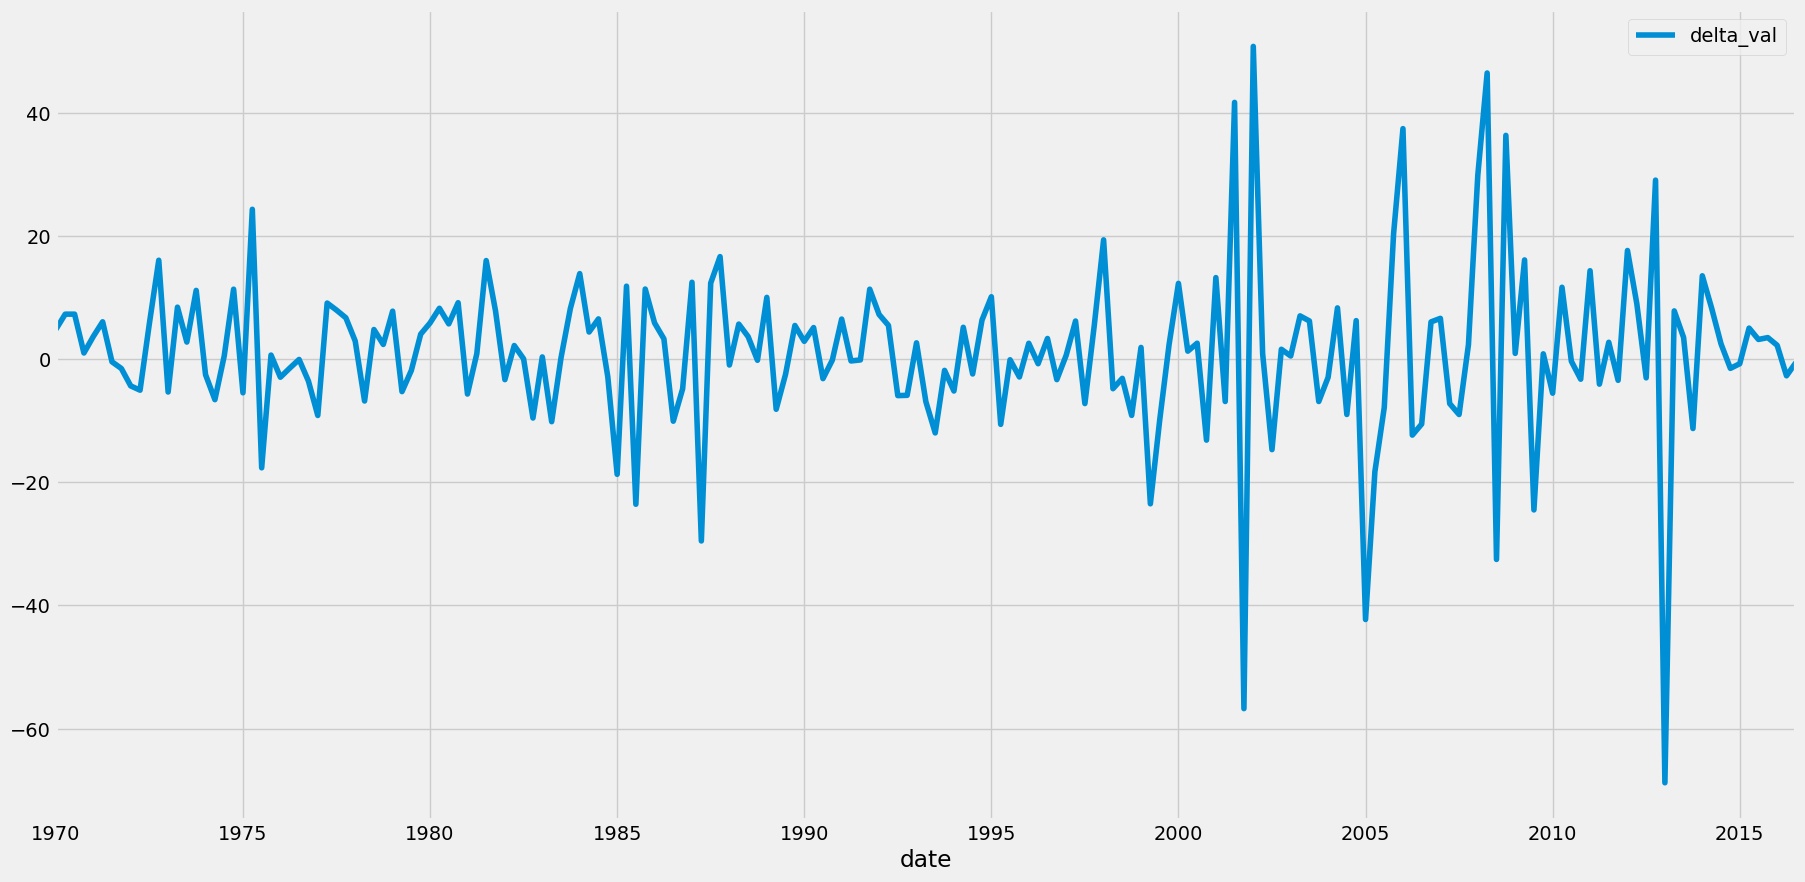

In [16]:
series = pd.read_csv(data + 'savings_change.csv')
series['date'] = pd.to_datetime(series['date'])
series.set_index('date').plot();

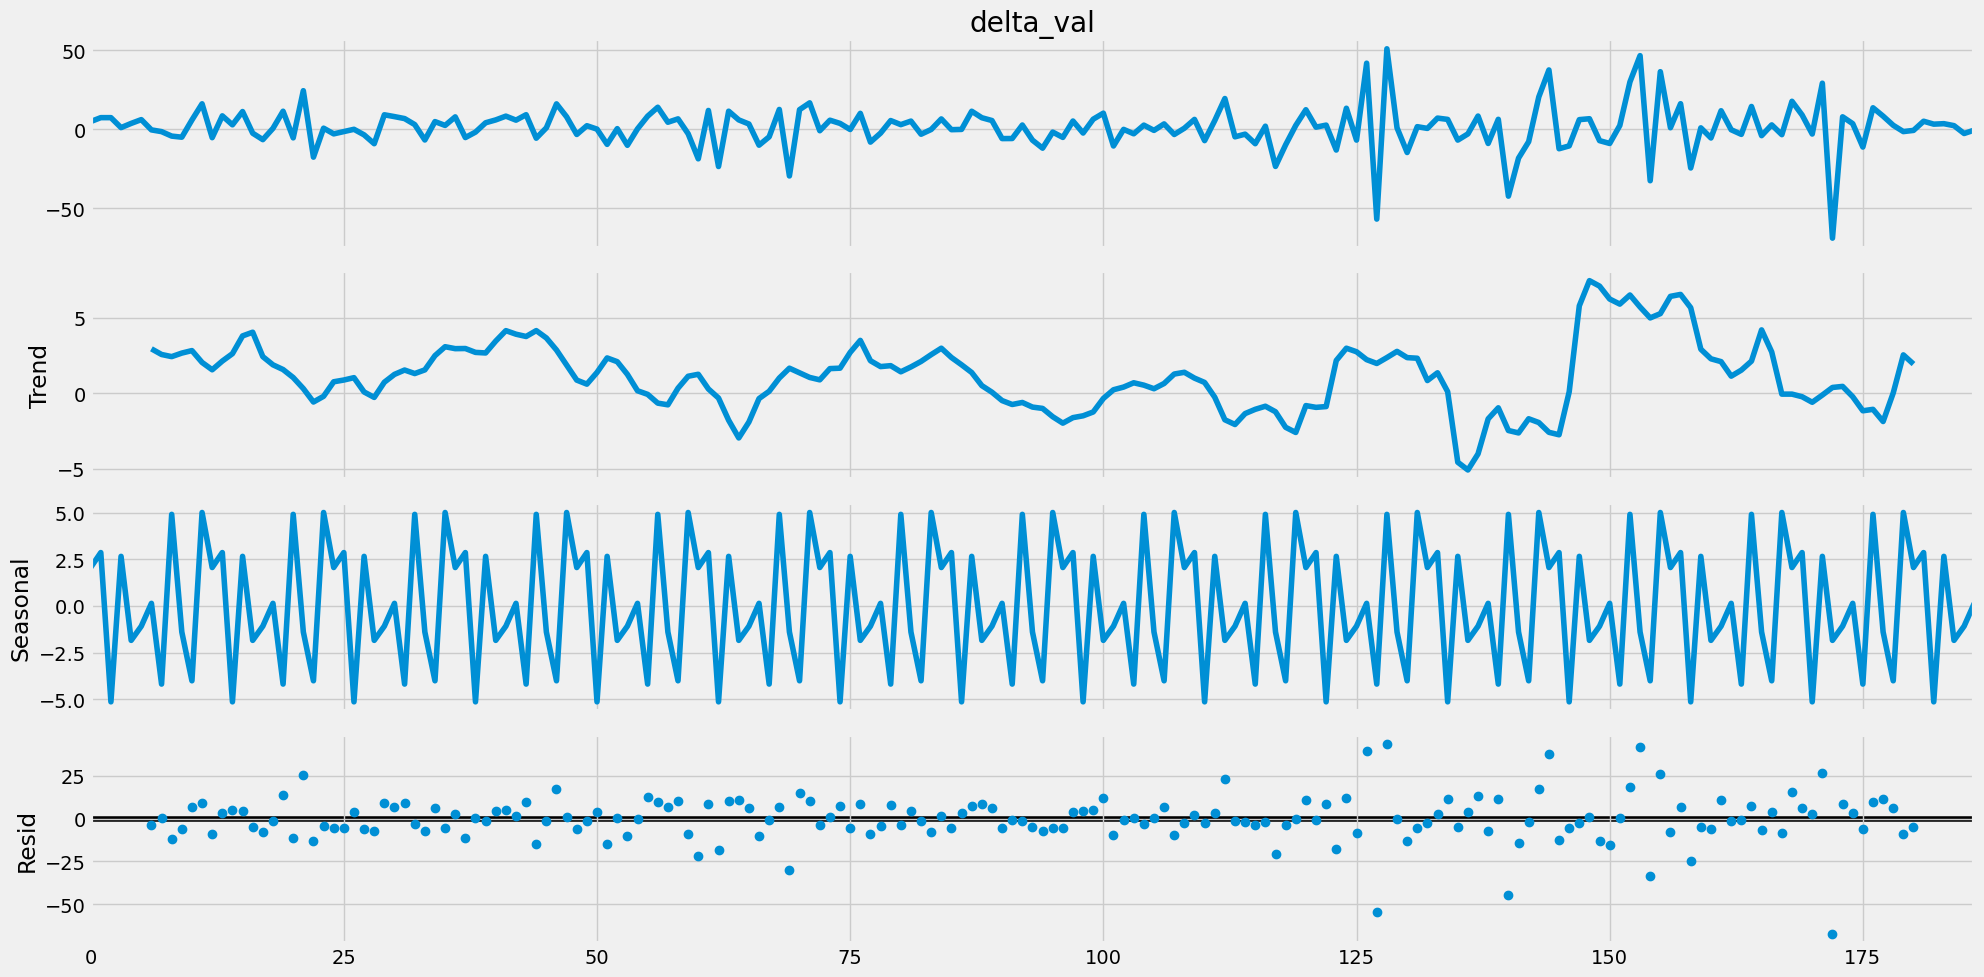

In [17]:
# Decomposing 
decomp = sm.tsa.seasonal_decompose(series['delta_val'], period=12)
figure = decomp.plot()
plt.show();

### Examples From Konrad's Datasets - Annual Averages of Daily Sunspot Areas

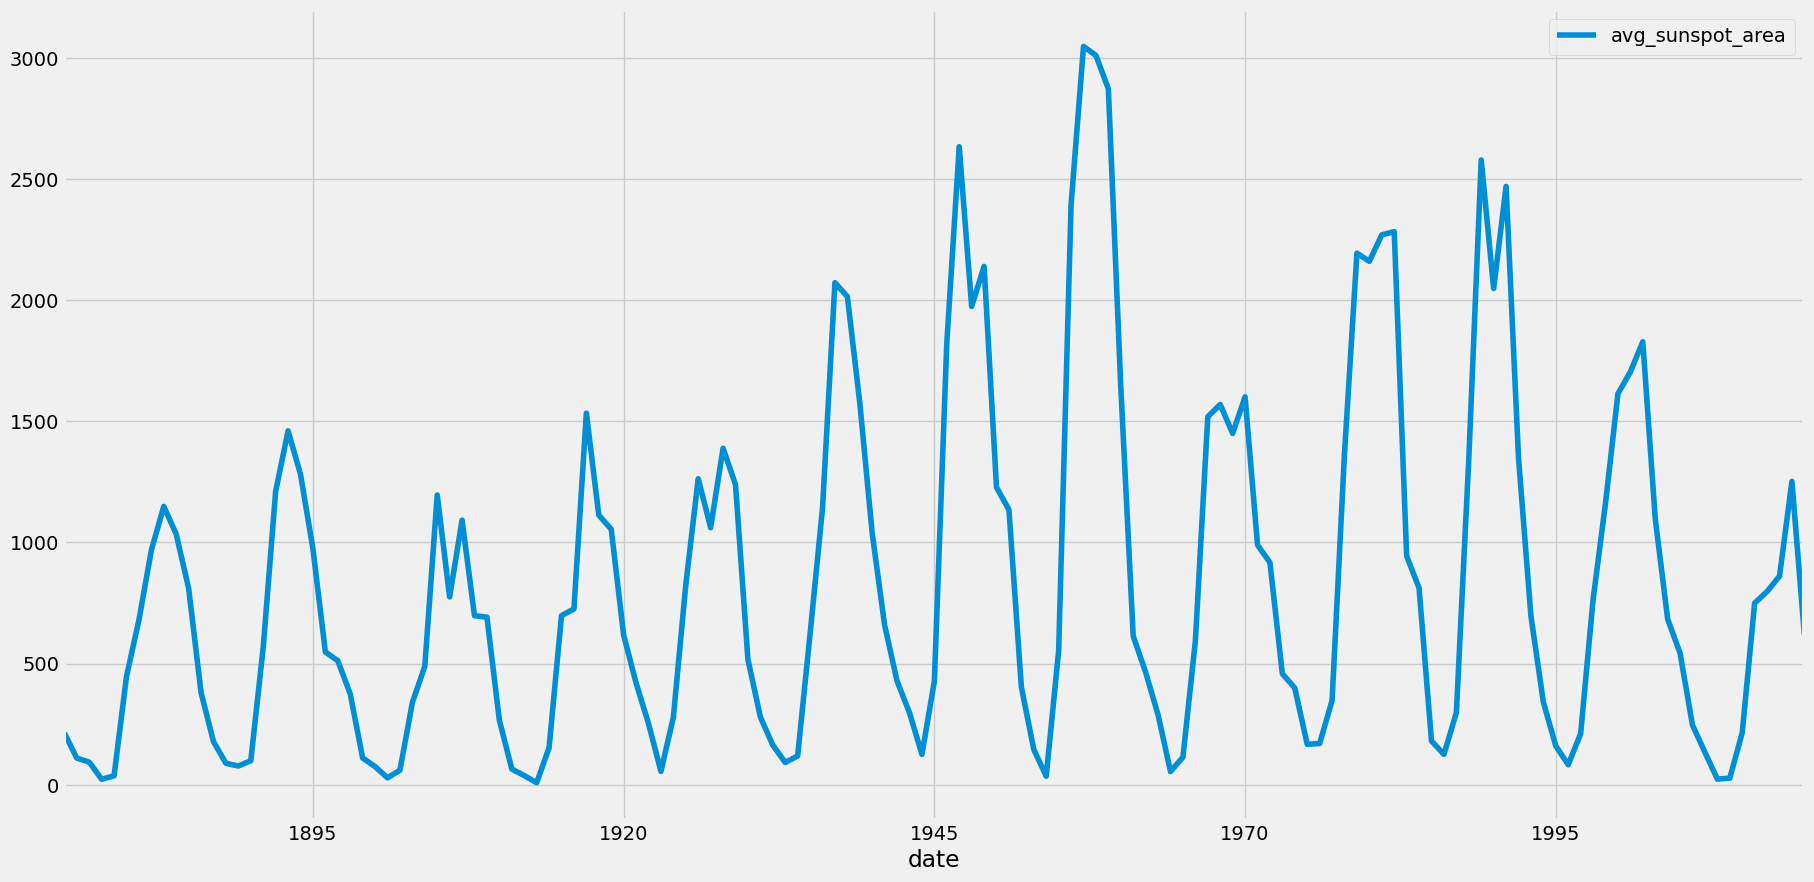

In [18]:
series = pd.read_csv(data + 'sunspots.csv')
series['date'] = pd.to_datetime(series['date'])
series.set_index('date').plot();

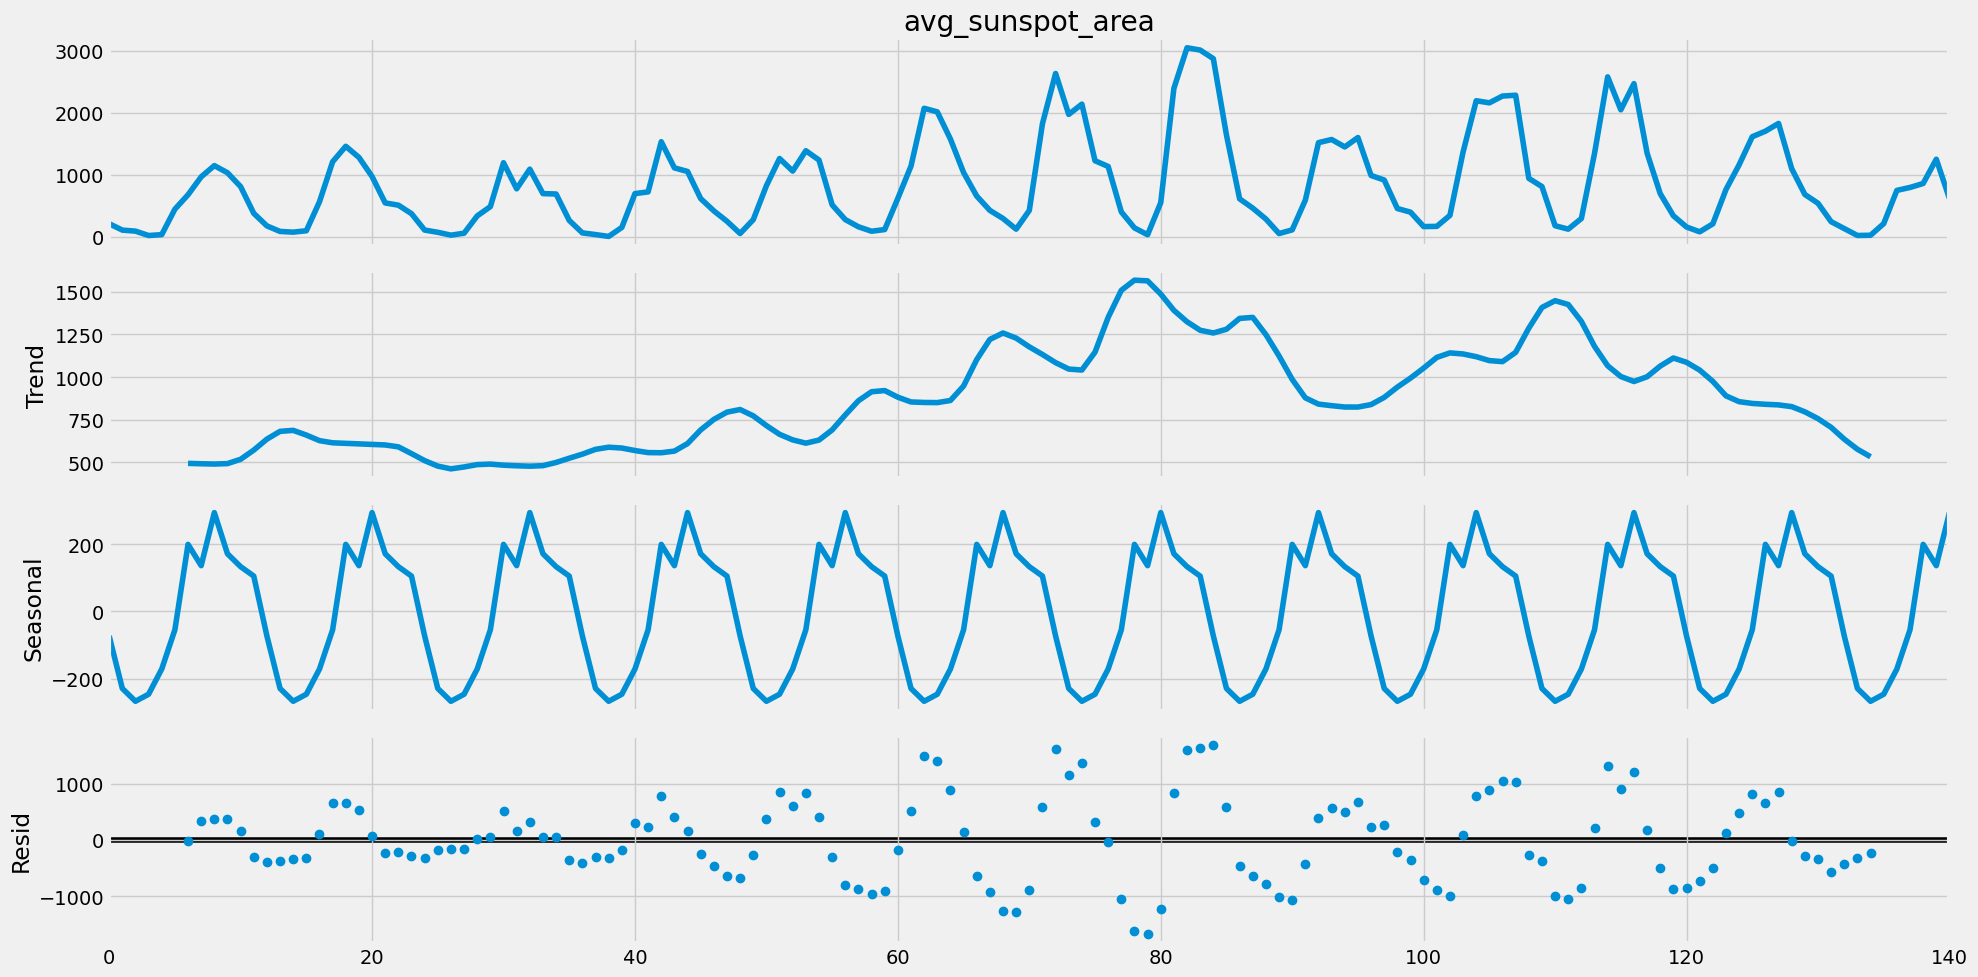

In [19]:
# Decomposing 
decomp = sm.tsa.seasonal_decompose(series['avg_sunspot_area'], period=12)
figure = decomp.plot()
plt.show();

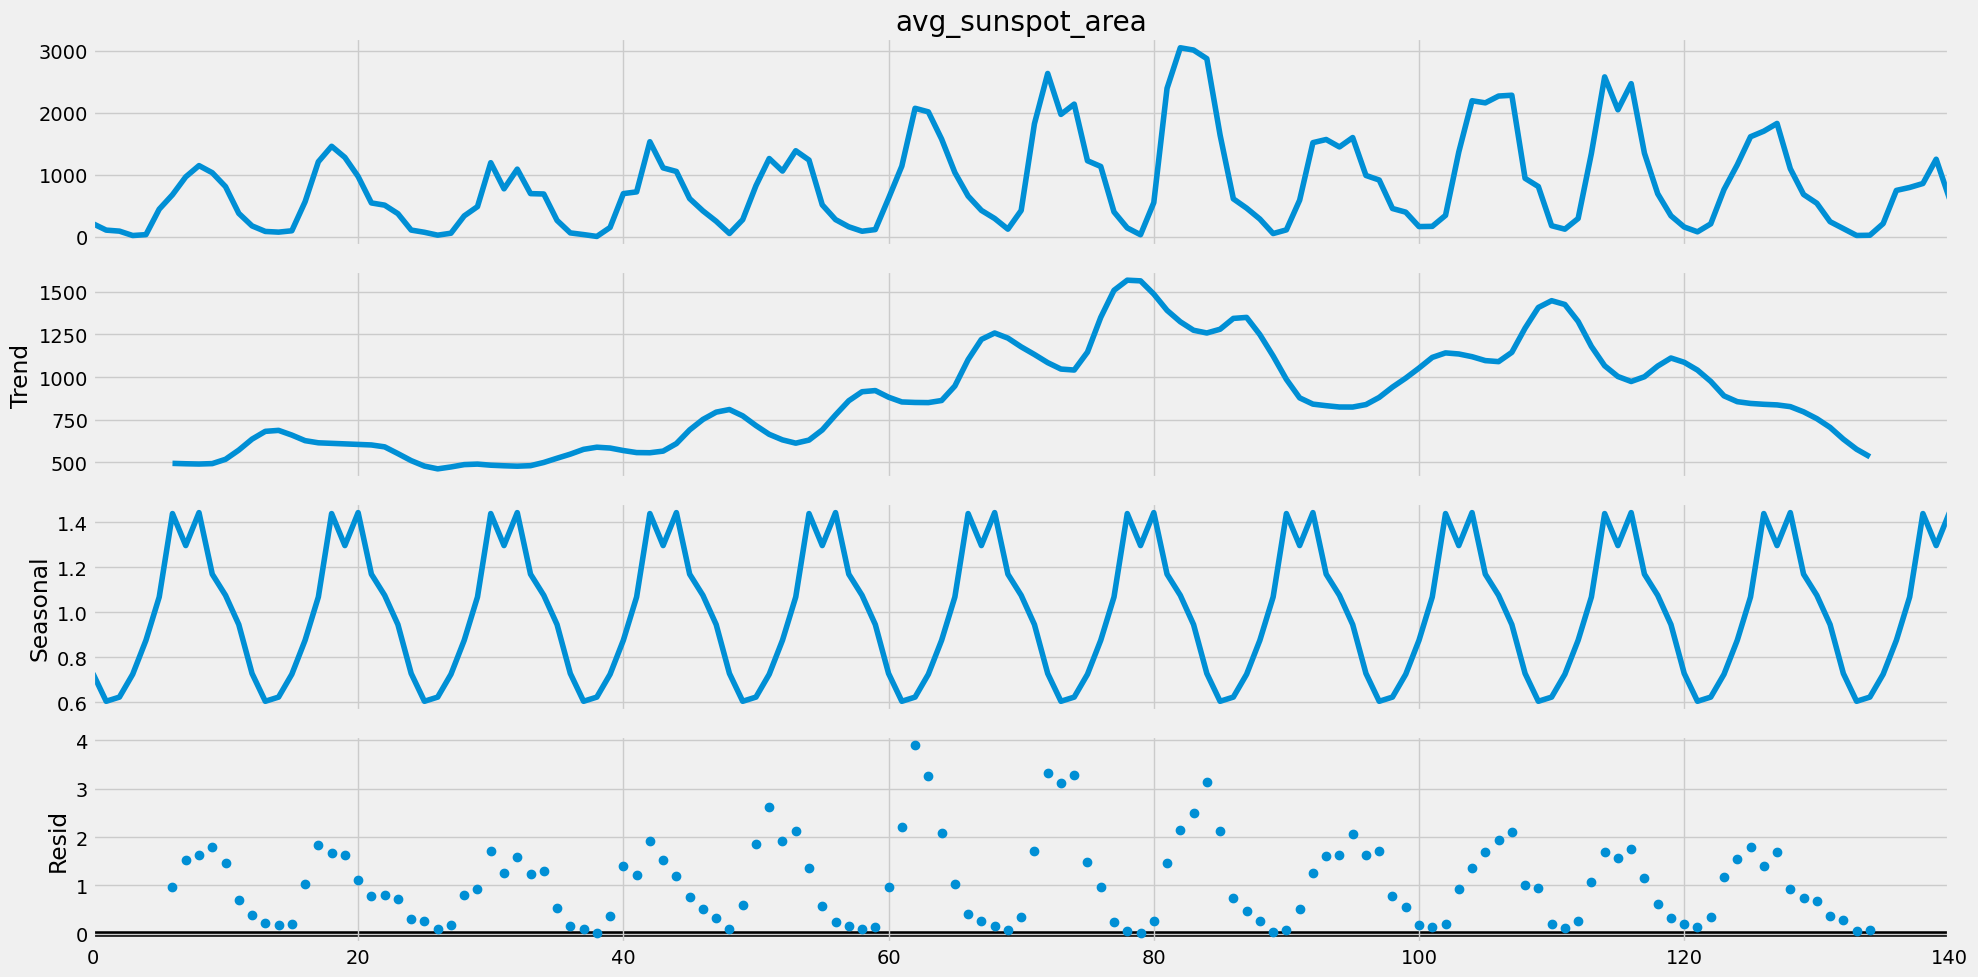

In [20]:
# Decomposing 
decomp = sm.tsa.seasonal_decompose(series['avg_sunspot_area'], period=12, model='multiplicative')
figure = decomp.plot()
plt.show();

We should always decompose data using both additive and multiplicative models especially when residuals have a lot of diverging patterns. 

Decomposition, as a rule should be used a 'first pass' tool, given its limitations in handling and explaining sophisticated data generating processes.

## Dependence and Stationarity